# SVM

## 概述

SVM(支持向量机)，是一种分类算法，用一个超平面将数据分成两份。N维的数据需要(N-1)维的超平面进行分割。
如图所示:
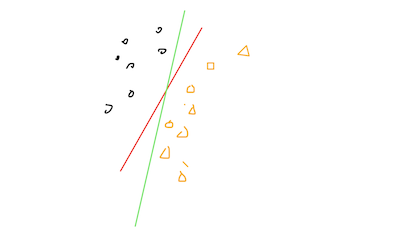

##  SVM工作原理

将黑色数据和黄色数据分割开的不只一条直线，上面就有红色和绿色两条，都能将样本数据分隔开来。但显然红色比绿色好。
红线和绿色都称之为超平面。最好的那条，称之为最大超平面。SVM就是要找最大超平面。

设最大超平面为:$Wx_i+b$，则对于所有的$Wx_i+b >=C$预测为1(即正类)，对所有的$Wx_i+b <= -C,预测为-1(负类)$  
C是一个常量，人为指定，默认一般为1

最大超平面:
    超平面到两边数据集的距离最大。

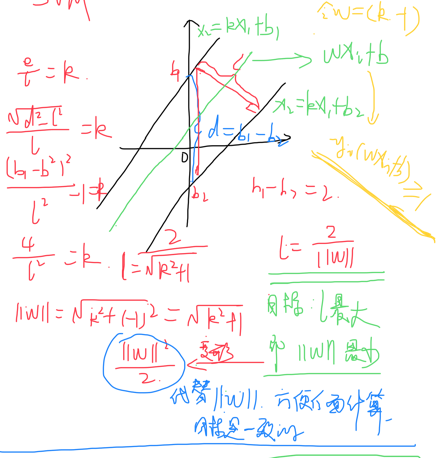

由计算可知，最大距离$l=\frac{2}{||W||}$，所以我们的目标是||W||最小。

因此得出**SVM最优化问题**:
$min(\frac{||W||^2}{2}) $   
$ s.t. 1-y_i(Wx_i+b) <= 0; i = 1,2,3...m $  

上面$\frac{||W||^2}{2} 与 \frac{2}{||W||} 目标都是要||W||最小，只是后面为了方面计算，写成前一种$  

## 最优化问题求解

### 拉格朗日乘子法

拉格朗日乘子法表示：  
L(x,y,λ) = f(x,y)+λg(x,y)

求解最大超平面，就是要求解我们上面的SVM主问题。主问题是一个带约束的，所以引入拉格朗日乘子来求解。

1.引入拉格朗日乘子 $a_1,a_2,...a_m >=0,得拉格朗日函数:$   
$L(W,b,a) = \frac{1}{2}||W||^2+\sum_{i=1}^{m}{} a_i(1-y_i(Wx_i+b))$  
并且有:设$g(x) = 1-y_i(Wx_i+b),λ=(a_1,a_2..a,m)$：  
g(x) <=0  
λ >=0  
λg(x) =  0  
2.求L(W,b,a) 对W,b的极小。对W,b 求偏导，并令偏导等于0，得：  
$W = \sum_{i=1}^{m}{}a_iy_ix_i $  
$\sum_{i=1}^{m}a_iy_i=0$  




3.利用2中得到的式子带入1并化简得：  
$L(W,b,a) = \sum_{i=1}^{m}{}a_i-\frac{1}{2}\sum_{i=1}^{m}{}\sum_{j=1}{m}{}a_ia_jy_iy_j(x_i·x_j)$  

### 对偶学习法

上面是要求W,b对于L(W,b,a)的极小值，转成对偶问题就是，求$min_{W,b}L(W,b,a)$对a的极大值

$max_amin_{W,b}L(W,b,a) = min_a[\frac{1}{2}\sum_{i=1}^{m}{}\sum_{j=1}{m}{}a_ia_jy_iy_j(x_i·x_j)-\sum_{i=1}^{m}{}a_i]$  
$s.t. \sum_{i=1}^{m}{} a_iy_i = 0; a_i >= 0$

现在就是要上式求解最优的$a_1,a_2...a_m$。这是一个动态规划问题，使用SMO算法求解。

### SMO算法

SMO算法的大概思想就是先取两个参数，如$a_1,a_2,假设 a_3,a_4...a_m$是固定的。先只优化$a_1和a_2$这两个参数。
反复迭代，最终得到最优的解。

SMO计算推导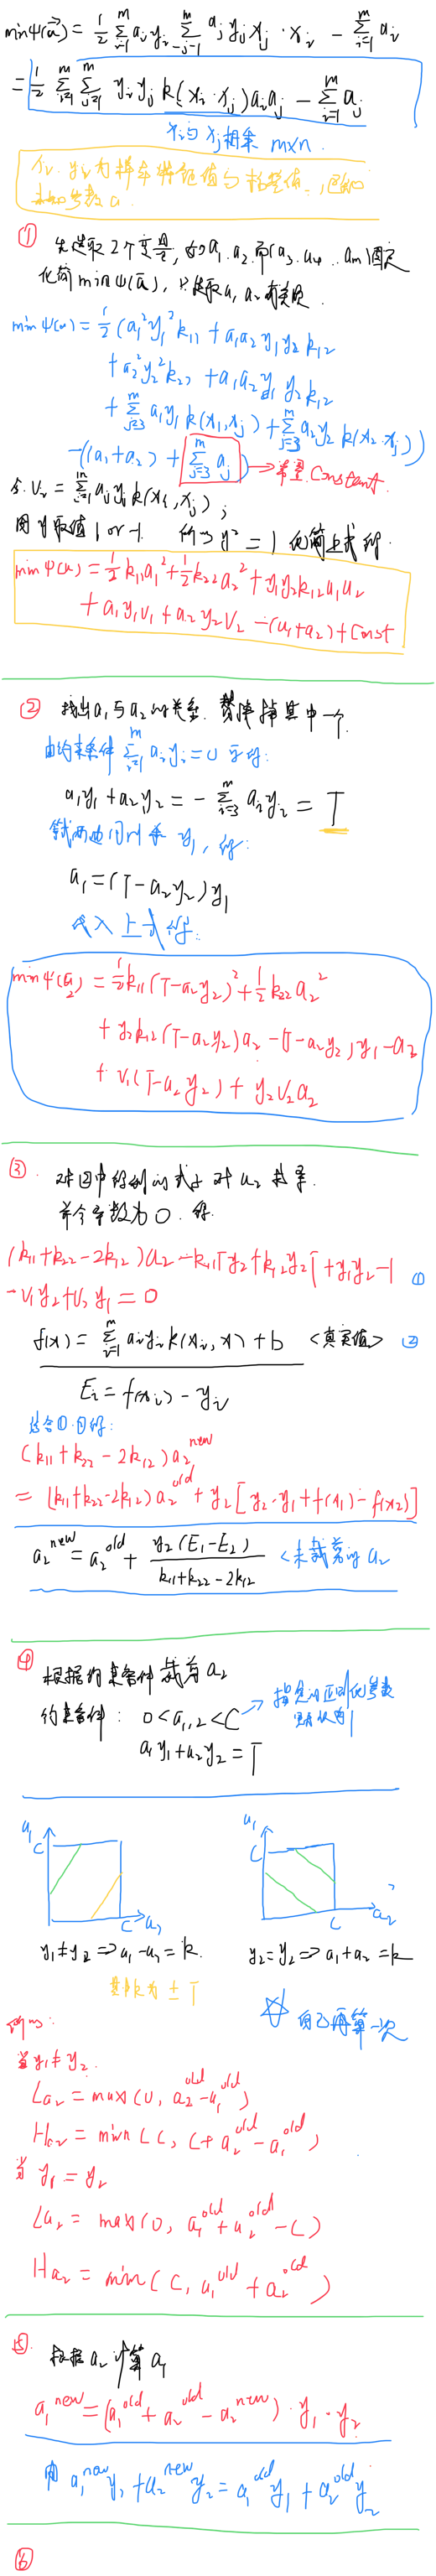

## 实现

### Package

In [12]:
import numpy as np
from utils import calc_accuracy_class
from utils import fl_score
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import pandas as pd 
from numpy import random

### 加载数据

In [13]:
X,y = datasets.load_iris(return_X_y=True)

In [14]:
#将数据分为训练集和测试集
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size = 0.20,random_state = 1)
print(f"train_X的大小为：{train_X.shape}")
print(f"tain_y的大小为：{train_y.shape}")
print(f"test_X的大小为：{test_X.shape}")
print(f"test_y的大小为：{test_y.shape}")

train_X的大小为：(120, 4)
tain_y的大小为：(120,)
test_X的大小为：(30, 4)
test_y的大小为：(30,)


### 先使用skearn看下效果

In [15]:
skmodel =LinearSVC(max_iter=1000,multi_class="crammer_singer")
skmodel.fit(train_X,train_y)
#预测
print("==== 训练集 ====== ")
pred_y = skmodel.predict(train_X)
fl_score(pred_y,train_y)

print("===== 测试集 ===== ")
pred_y = skmodel.predict(test_X)
fl_score(pred_y,test_y)


==== 训练集 ====== 
0 类的fl_score 为:1.0
1 类的fl_score 为:0.9577464788732395
2 类的fl_score 为:0.967032967032967
===== 测试集 ===== 
0 类的fl_score 为:1.0
1 类的fl_score 为:1.0
2 类的fl_score 为:1.0


/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


接下来，自己实现

### SMO算法

In [16]:
def select_j_rand(i, m):
    '''
    随机选择第二个参数的index j
    '''
    j = i
    while (j == i):
        j = random.randint(0, m-1)
    return j


In [17]:
def clipped_alpha(alpha_new_x, yi, yj, alpha_i, alpha_j, C):
    '''
    裁剪alpha
    '''
    L = H = 0
    if yi != yj:
        k = alpha_j - alpha_i
        # 确定下界
        L = max(k, 0)
        # 确定上界
        H = min(C, C+k)
    else:
        k = alpha_i+alpha_j
        L = max(0, k - C)
        H = min(k, C)
    # alpha_new 必须介于L和H之间
    alpha_new_x = max(L, alpha_new_x)
    alpha_new_x = min(H, alpha_new_x)

    return alpha_new_x, L, H

In [45]:
def smo_simple(X_train, y_train, C, max_iter):
    m, n = X_train.shape
    alpha = np.random.rand(m)
    b = 0
    iters = 0
    cost_plot = list()
    iteration = range(1,max_iter+1)
    while iters < max_iter:
        iters += 1
        for i in range(0, m):
            # 求f(xi)的值
            fxi = np.sum(alpha * y_train *
                         np.dot(X_train, X_train[i].transpose()))+b
            # 求实际值与预测值之间的差
            Ei = fxi - y_train[i]

            # 随机选取第二个参数j， j!=i
            j = select_j_rand(i, m)
            fxj = np.sum(alpha * y_train *
                         np.dot(X_train, X_train[j].transpose()))+b
            Ej = fxj - y_train[j]

            # Kii+Kjj-2Kij
            eta = np.dot(X_train[i], X_train[i].transpose())+np.dot(X_train[j],
                                                                    X_train[j].transpose()) - 2*np.dot(X_train[i], X_train[j].transpose())

            if(eta == 0) :
                continue
            alpha_j_new = (
                y_train[j]*(Ei - Ej))/eta + alpha[j]

            alpha_i_old = alpha[i].copy()
            alpha_j_old = alpha[j].copy()

            # 根据约束条件裁剪alpha_j_new
            alpha_j_new,L,H =clipped_alpha(
                alpha_j_new, y_train[i], y_train[j], alpha[i], alpha[j], C)
            if ( L == H ) :
              #  print("第"+repr(iters)+"次循环:L=H="+repr(L)+",i="+repr(i))
                continue



            alpha[j] = alpha_j_new

            if(abs(alpha_j_new - alpha_j_old) < 0.0001) :
                #print("第"+repr(iters)+"次循环,改变很小，无需优化"+repr(j))
                continue
            # 根据alpha_j 求alpha_i
            alpha_i_new = alpha[i] + (alpha_j_old - alpha_j_new)*y_train[i]*y_train[j]

          # 更新alpha
            alpha[i] = alpha_i_new


            # 更新b
            b1 = (alpha_i_old-alpha[i])*y_train[i]*np.dot(X_train[i], X_train[i].transpose())+(
                alpha_j_old-alpha[j])*y_train[j] * np.dot(X_train[j], X_train[i].transpose())+b-Ei

            b2 = (alpha_i_old-alpha[i])*y_train[i]*np.dot(X_train[i], X_train[j].transpose())+(
                alpha_j_old-alpha[j])*y_train[j] * np.dot(X_train[j], X_train[j].transpose())+b-Ej

            if 0< alpha[i] and C > alpha[i]:
                b = b1
            elif 0< alpha[j] and C > alpha[j]:
                b = b2
            else:
                b = (b1+b2)/2
    return alpha,b

### SVM基础模型

SVM是用来解决2分类问题的。所以一个SVM模型只能区分两类。若要区分多类，则需要多个SVM模型。  
若有N个分类，则需要N或（N-1)个SVM模型

In [51]:
class BasicSVMModel:
    def __init__(self,category):
        self.category = category
        self.X = None
        self.y = None
        self.w = None
        self.b = None
        self.C = None
        
    def fit(self,train_X,train_y,C):
        self.X = train_X
        self.y = train_y
        self.C = C
        m = np.size(self.X, axis=0)  # 样本个数
        # 使用SMO算法最优化对偶问题，求得最优的alpha
        max_iter = 1000
        optimize_alpha,b = smo_simple(train_X, train_y, C, max_iter)
        # 求w
        self.w = np.dot(train_X.transpose(), optimize_alpha*train_y)
        # 求b，由KKT条件得：(1-y(wx+b)) = 0。求所有支持向量的均值
        self.b = np.sum(train_y - np.dot(train_X, self.w))/m
    
    
    #决策
    def sign(self,X):
        f_x =  np.dot(X, self.w) + self.b
        # 决策函数决策，返回1, -1 。1 表示正类。即属于self.category
        sign_fx = np.where(f_x > 0, 1, -1)
        return sign_fx
        

In [54]:
class SVMModel:
    def __init__(self):
        self.model_list =[]#因为一个SVM只能做二分类，所以通过构造N-1个基本的SVM来进行多分类
        
        
    def fit(self, train_X, train_y):
        '''
        训练
        '''
        m = X.shape[0]  # 样本个数
        # 获取所有y的取值,然后将y的结果集拆分成n个结果集，每个结果集判断一种y的取值，是为1，不是为-1
        y_set = set(train_y)
        for y in y_set:
            y_sub_train = np.where(train_y == y, 1, -1)
            basic_model = BasicSVMModel(y)
            C = 1.5
            basic_model.fit(train_X, y_sub_train,C)
            self.model_list.append(basic_model)
    
    def predict(self, X):
        m = np.size(X, axis=0)  # 样本个数
        y_pred = np.zeros(m)
        print("===== 预测 ====== ")
        # 让样本经过每一个模型进行预测
        need_pred_X = X
        unjudge_samples = np.array(range(0,m))
        for index, model in enumerate(self.model_list):
            sign_x = model.sign(need_pred_X)
            if  index == (len(self.model_list) - 1):
                # 最后一个模型，无需再分类
                y_pred[unjudge_samples] = model.category
            else:
                negtive_columns=np.where(sign_x != 1)
                positive_columns=np.where(sign_x == 1)

                need_pred_X = X[negtive_columns]
                y_pred[unjudge_samples[positive_columns]] = model.category
                unjudge_samples = unjudge_samples[negtive_columns]
        return y_pred.astype(int)

In [55]:
model = SVMModel()
model.fit(train_X,train_y)

pred_y = model.predict(train_X)
fl_score(np.squeeze(pred_y),train_y)
calc_accuracy_class(pred_y,train_y)

===== 预测 ====== 
0 类的fl_score 为:0.8297872340425533
1 类的fl_score 为:0.2692307692307693
2 类的fl_score 为:0.7446808510638298


0.675